# Overview

In this notebook, we conduct data cleaning of the merged table. 

**Author**: Oscar Javier Bastidas Jossa. 

**Email**: oscar.jossa@deusto.es.

In [1]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
# Read data and assign the index

df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9137)

## Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

In [3]:
# Removing all columns with zero values

columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.shape

(46192, 7357)

In [5]:
# Removing the Initial columns that containt the total number of series 

columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6905)

In [6]:
# Drop columns to only itereate over the exercises

'''df_exercises = df.drop(columns=['session_executions_updated_at', 'user_programs_user_id', 'session_executions_reps_executed',
                                  'session_executions_summary_updated_at', 'session_executions_updated_at', 'sessions_time_duration',
                                   'user_programs_user_id', 'users_updated_at'])
'''
df_exercises = df.drop(columns=['session_executions_updated_at', 'user_programs_user_id', 'date'])

In [7]:
def add_count_and_sum_columns(df):
    """
    Add the folloiwng columns to a DataFrame.
    total reps: Sum of all the rep values executed during the session.
    total time: Sum of the total time values for all the exercises during the session.
    total_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    total_time_per_exercise: Sum of the time values during the session per exercise.
    count_reps: The count of reps exercises executed.
    count_time: The count of time exercises executed.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        total_reps = {'total_reps':0}
        total_reps_per_exercise = {}
        count_times = {}
        total_time = {'total_time':0}
        total_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = 0
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] = total_reps_per_exercise[group_name_reps + '_total_reps_per_exercise'] + row[item]
                total_reps['total_reps'] = total_reps['total_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = 0
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = total_time_per_exercise[group_name_time + '_total_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    total_time_per_exercise[group_name_time + '_total_time_per_exercise'] = total_time_per_exercise[group_name_time + '_total_time_per_exercise'] + row[item]
                total_time['total_time'] = total_time['total_time'] + row[item]
            else:
                pass

        count_reps['sum_reps'] = sum(count_reps.values())
        count_times['sum_times'] = sum(count_times.values())

        count_reps_all[index] = count_reps | total_reps | total_reps_per_exercise | count_times | total_time | total_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [8]:
df_series_recalculated = add_count_and_sum_columns(df)

Important: Uncomment the following lines to test the final df with an individual user from the session execution summary table from the merge file

individual_session_execution = df_series_recalculated.loc[746205, :]
individual_session_execution.loc[individual_session_execution.astype(bool)]['total_reps']

In [11]:
# Uncomment when is useful to store the index of the final session_executions
# with open('../data/index_session_execution.npy', 'wb') as f:
#    np.save(f, np.array(df_series_recalculated.index))

## Initial statistics descriptive 

In [13]:
df_describe = df_series_recalculated.describe()
df_describe = df_describe.drop(columns=['user_programs_user_id', 'sum_times', 'sum_reps', 'total_reps', 'total_time'])
df_describe

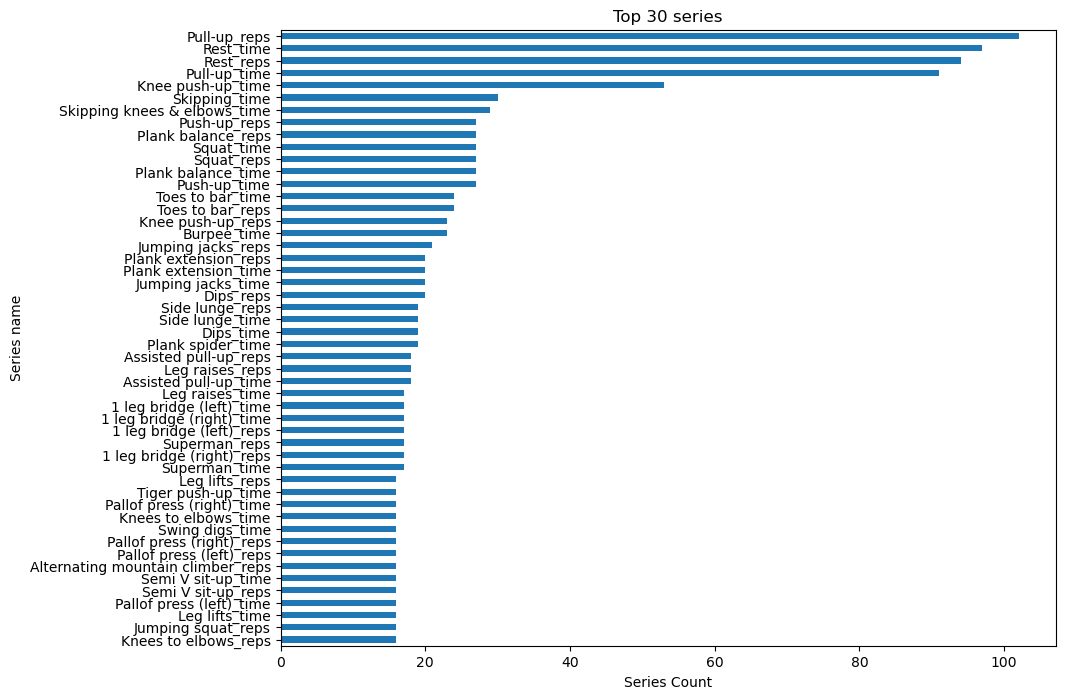

In [72]:
# Get the max to correct outliers
max_description = df_describe.loc['max', :].sort_values(ascending=False)
max_series = max_description[~max_description.keys().str.contains('_reps_')]
max_series = max_series[~max_series.keys().str.contains('_time_')]

# Getting the first 30 values
max_series = max_series[0:50]

# Sorting and plotting
ax = max_series.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Top 30 series')
ax.set_xlabel('Series Count')
ax.set_ylabel('Series name')

# Show the plot
plt.show()

In [7]:
max_reps = max_description[max_description.keys().str.contains('_time_')]
max_reps

Diver_time_1                         4893.0
Pivot lunges (left)_time_2           3861.0
Rest_time_1                          3752.0
Plank balance_time_1                 3719.0
Rest_time_2                          3667.0
                                      ...  
Roll-out with rings 2_time_11           1.0
Roll-out with rings 2_time_10           1.0
Rocket with weight (left)_time_10       1.0
Ring dips 2_time_12                     1.0
Tricep extension_time_8                 1.0
Name: max, Length: 3550, dtype: float64

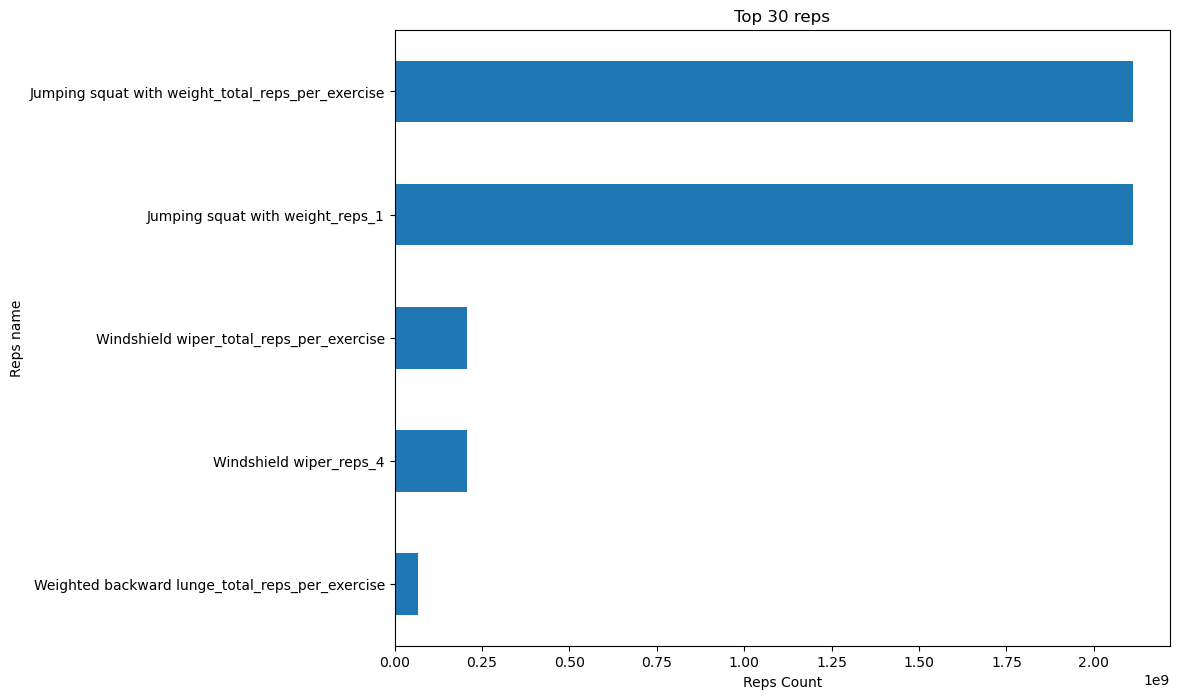

In [73]:
# Get the max to correct outliers
max_description = df_describe.loc['max', :].sort_values(ascending=False)
max_reps = max_description[max_description.keys().str.contains('_reps_')]
#max_series = max_series[~max_series.keys().str.contains('_time_')]

# Getting the first 30 values
max_reps = max_reps[0:5]

# Sorting and plotting
ax = max_reps.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Top 30 reps')
ax.set_xlabel('Reps Count')
ax.set_ylabel('Reps name')

# Show the plot
plt.show()

In [137]:
columns_without_reps_and_time_recalculated = df_series_recalculated.columns[~((df_series_recalculated.columns.str.contains("_reps_")) |
                                                                             (df_series_recalculated.columns.str.contains("_time_")) |      
                                                                             (df_series_recalculated.columns.str.contains("session_executions_updated_at")) |
                                                                             (df_series_recalculated.columns.str.contains("user_programs_user_id")) |
                                                                             (df_series_recalculated.columns.str.contains("date")) )]

unique_exercises = set()
for name in columns_without_reps_and_time_recalculated:
    cleaned_name = name.replace('_reps', '').replace('_time', '')
    unique_exercises.add(cleaned_name)

# Convert the set to a list and sort it
unique_exercises = sorted(list(unique_exercises))

In [ ]:
# df_describe.loc['max', :].sort_values(ascending=False)[0:1000]
top_30_exercises = df.drop(columns=['session_executions_updated_at', 'user_programs_user_id', 'date']).astype(bool).sum(axis=0)
top_30_exercises = top_30_exercises[~top_30_exercises.keys().str.contains('_reps_')]
top_30_exercises = top_30_exercises[~top_30_exercises.keys().str.contains('_time_')]
top_30_exercises = top_30_exercises.sort_values(ascending=False)[1:30] # Ommiting Rest that is the zero value

# Assuming top_30_exercises is your Series containing exercise names and their counts
ax = top_30_exercises.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Top 30 Exercises')
ax.set_xlabel('Count')
ax.set_ylabel('Exercise')

# Show the plot
plt.show()